# Immitation of AFGROW-Style Vertex Value Prediction

In [13]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d
import pandas as pd

Dataset shape: (92149, 5)
Features: w_over_r, a_over_c, a_over_t, R_over_t
Target: Kbearing_c

Training data: 73719 samples
Test data: 18430 samples

Feature ranges in training data:
w_over_r: [1.6000, 1000.0000]
a_over_c: [0.1000, 10.0000]
a_over_t: [0.1000, 0.9500]
R_over_t: [0.1000, 10.0000]
Kbearing_c: [0.7942, 880.8000]

Unique values in the training dataset:
w_over_r: 44
a_over_c: 25
a_over_t: 10
R_over_t: 27
Kbearing_c: 15907


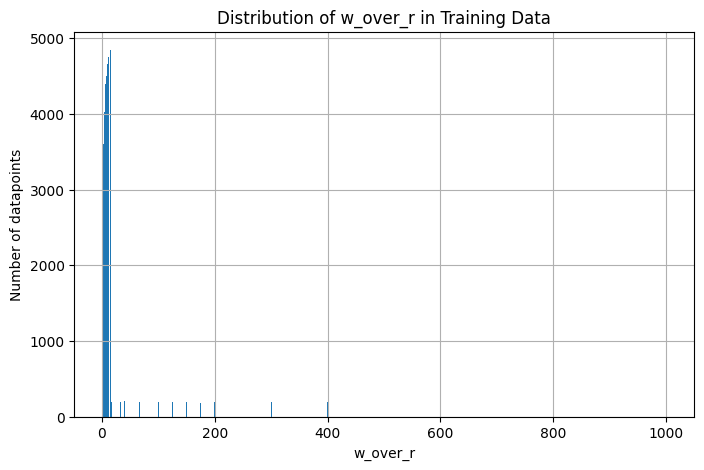

Unique w_over_r: [   1.60000002    1.79999995    2.            2.20000005    2.4000001
    2.79999995    3.20000005    3.5999999     4.            4.5999999
    5.19999981    5.80000019    6.4000001     7.            8.
   10.           12.           12.5          14.30000019   15.
   16.70000076   20.           25.           33.29999924   40.
   44.40000153   50.           57.09999847   66.69999695   80.
  100.          125.          149.8999939   175.          200.
  225.          250.          300.29998779  400.          500.
  599.90002441  700.29998779  800.         1000.        ]
Counts: [2310 2576 2857 3043 3154 3404 3597 3782 3915 4021 4180 4267 4391 4393
 4506 4653 4745  202  197 4843  194  204  200  201  208  201  203  200
  191  190  195  201  195  181  196  192  190  196  201  199  185  196
  182  182]


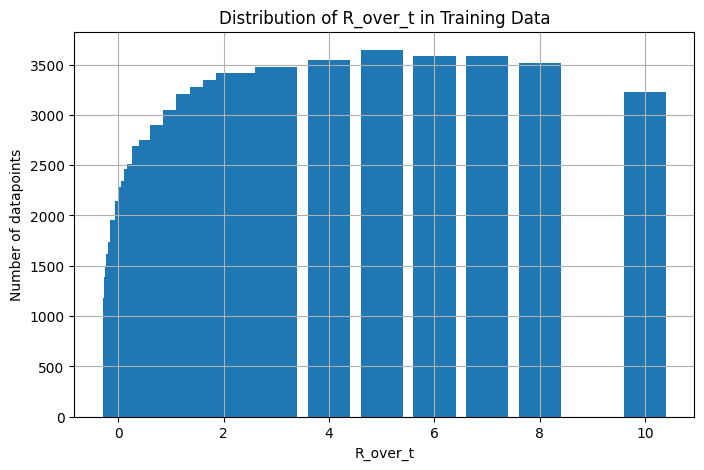

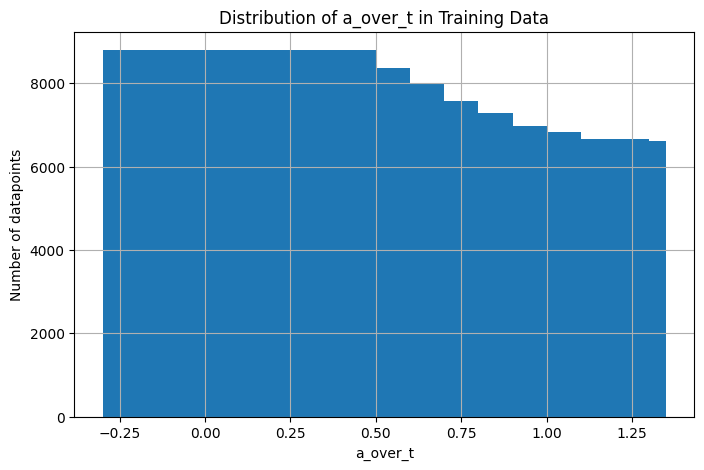

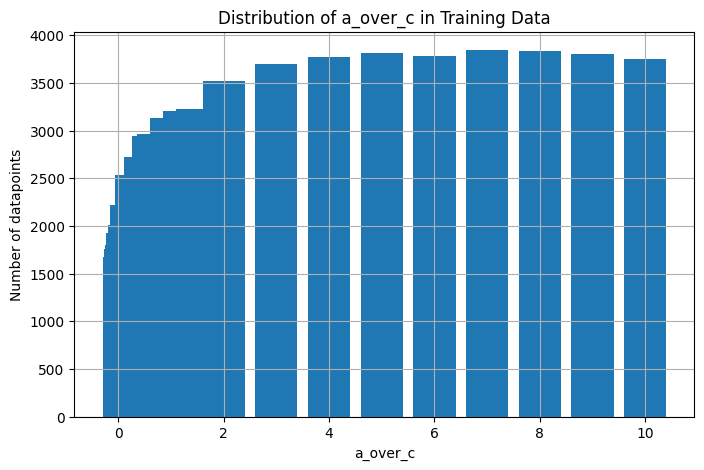

In [14]:
# Load the dataset and perform train/test split (matching model_experimentation.py)
dataset_name = 'four_params_Kbearing_c'
data_array = np.load(f'../data/{dataset_name}.npy')

print(f"Dataset shape: {data_array.shape}")
print(f"Features: w_over_r, a_over_c, a_over_t, R_over_t")
print(f"Target: Kbearing_c")

# Feature indices (based on your description)
w_over_r_idx = 0
a_over_c_idx = 1  
a_over_t_idx = 2
R_over_t_idx = 3
Kbearing_c_idx = 4

# Shuffle the dataset rows with the same seed as model_experimentation.py
np.random.seed(42)
np.random.shuffle(data_array)

# Split the data into 80/20 train/test sets (same as model_experimentation.py)
train_data = data_array[:int(0.8 * len(data_array))]
test_data = data_array[int(0.8 * len(data_array)):]

# Extract features and labels
X_train = train_data[:, :-1]  # First 4 columns: w_over_r, a_over_c, a_over_t, R_over_t
y_train = train_data[:, -1]   # Last column: Kbearing_c
X_test = test_data[:, :-1]
y_test = test_data[:, -1]

print(f"\nTraining data: {X_train.shape[0]} samples")
print(f"Test data: {X_test.shape[0]} samples")

# Display feature ranges
feature_names = ['w_over_r', 'a_over_c', 'a_over_t', 'R_over_t']
print(f"\nFeature ranges in training data:")
for i, name in enumerate(feature_names):
    print(f"{name}: [{X_train[:, i].min():.4f}, {X_train[:, i].max():.4f}]")
print(f"Kbearing_c: [{y_train.min():.4f}, {y_train.max():.4f}]")

# Display the number of unique values for each feature in the training dataset
print(f"\nUnique values in the training dataset:")
for i, name in enumerate(feature_names):
    print(f"{name}: {np.unique(X_train[:, i]).size}")
print(f"Kbearing_c: {np.unique(y_train).size}")

# Plot number of datapoints for each unique w_over_r value
unique_w_over_r, counts_w_over_r = np.unique(X_train[:, w_over_r_idx], return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_w_over_r, counts_w_over_r)
plt.xlabel('w_over_r')
plt.ylabel('Number of datapoints')
plt.title('Distribution of w_over_r in Training Data')
plt.grid()
plt.show()
print(f"Unique w_over_r: {unique_w_over_r}")
print(f"Counts: {counts_w_over_r}")

# Plot number of datapoints for each unique R_over_t value
unique_R_over_t, counts_R_over_t = np.unique(X_train[:, R_over_t_idx], return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_R_over_t, counts_R_over_t)
plt.xlabel('R_over_t')
plt.ylabel('Number of datapoints')
plt.title('Distribution of R_over_t in Training Data')
plt.grid()
plt.show()

# Plot number of datapoints for each unique a_over_t value
unique_a_over_t, counts_a_over_t = np.unique(X_train[:, a_over_t_idx], return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_a_over_t, counts_a_over_t)
plt.xlabel('a_over_t')
plt.ylabel('Number of datapoints')
plt.title('Distribution of a_over_t in Training Data')
plt.grid()
plt.show()

# Plot number of datapoints for each unique a_over_c value
unique_a_over_c, counts_a_over_c = np.unique(X_train[:, a_over_c_idx], return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_a_over_c, counts_a_over_c)
plt.xlabel('a_over_c')
plt.ylabel('Number of datapoints')
plt.title('Distribution of a_over_c in Training Data')
plt.grid()
plt.show()

In [3]:
# AFGROW-Style Interpolation Function
def afgrow_interpolation(target_point, training_data, training_labels, feature_names):
    """
    Perform AFGROW-style interpolation to predict Kbearing_c
    
    Parameters:
    target_point: array of [w_over_r, a_over_c, a_over_t, R_over_t] for prediction
    training_data: X_train array
    training_labels: y_train array
    feature_names: list of feature names
    
    Returns:
    interpolated_value: predicted Kbearing_c
    """
    
    target_w_r, target_a_c, target_a_t, target_R_t = target_point
    
    # print(f"🎯 Target point: w/r={target_w_r:.3f}, a/c={target_a_c:.3f}, a/t={target_a_t:.3f}, R/t={target_R_t:.3f}")
    
    # Step 1: Find nearest w/r values
    w_r_values = training_data[:, w_over_r_idx]
    w_r_unique = np.unique(w_r_values)
    
    # Find the two closest w/r values
    w_r_diffs = np.abs(w_r_unique - target_w_r)
    w_r_sorted_idx = np.argsort(w_r_diffs)
    
    if len(w_r_unique) == 1 or w_r_diffs[w_r_sorted_idx[0]] == 0:
        # Exact match or only one w/r value
        nearest_w_r = [w_r_unique[w_r_sorted_idx[0]]]
        w_r_weights = [1.0]
    else:
        # Two nearest w/r values for interpolation
        nearest_w_r = w_r_unique[w_r_sorted_idx[:2]]
        w_r_distances = w_r_diffs[w_r_sorted_idx[:2]]
        # Inverse distance weighting
        w_r_weights = 1.0 / (w_r_distances + 1e-10)
        w_r_weights = w_r_weights / np.sum(w_r_weights)
    
    # print(f"📍 Nearest w/r values: {nearest_w_r} (weights: {w_r_weights})")
    
    interpolated_results = []
    
    # Process each selected w/r value
    for w_r_val, w_r_weight in zip(nearest_w_r, w_r_weights):
        # Filter data for this w/r value
        w_r_mask = np.abs(training_data[:, w_over_r_idx] - w_r_val) < 1e-10
        w_r_subset_data = training_data[w_r_mask]
        w_r_subset_labels = training_labels[w_r_mask]
        
        if len(w_r_subset_data) == 0:
            continue
            
        # print(f"  📊 w/r={w_r_val:.3f}: {len(w_r_subset_data)} data points")
        
        # Step 2: Find nearest R/t values within this w/r subset
        R_t_values = w_r_subset_data[:, R_over_t_idx]
        R_t_unique = np.unique(R_t_values)
        
        R_t_diffs = np.abs(R_t_unique - target_R_t)
        R_t_sorted_idx = np.argsort(R_t_diffs)
        
        if len(R_t_unique) == 1 or R_t_diffs[R_t_sorted_idx[0]] == 0:
            nearest_R_t = [R_t_unique[R_t_sorted_idx[0]]]
            R_t_weights = [1.0]
        else:
            nearest_R_t = R_t_unique[R_t_sorted_idx[:2]]
            R_t_distances = R_t_diffs[R_t_sorted_idx[:2]]
            R_t_weights = 1.0 / (R_t_distances + 1e-10)
            R_t_weights = R_t_weights / np.sum(R_t_weights)
        
        # print(f"    📍 Nearest R/t values: {nearest_R_t} (weights: {R_t_weights})")
        
        R_t_results = []
        
        # Process each selected R/t value
        for R_t_val, R_t_weight in zip(nearest_R_t, R_t_weights):
            # Filter data for this w/r and R/t combination
            R_t_mask = np.abs(w_r_subset_data[:, R_over_t_idx] - R_t_val) < 1e-10
            final_subset_data = w_r_subset_data[R_t_mask]
            final_subset_labels = w_r_subset_labels[R_t_mask]
            
            if len(final_subset_data) == 0:
                continue
                
            # print(f"      📊 R/t={R_t_val:.3f}: {len(final_subset_data)} data points")
            
            # Step 3: 2D interpolation in a/c and a/t space
            a_c_values = final_subset_data[:, a_over_c_idx]
            a_t_values = final_subset_data[:, a_over_t_idx]
            
            if len(final_subset_data) == 1:
                # Only one point - use it directly
                interpolated_K = final_subset_labels[0]
                # print(f"        📌 Single point interpolation: {interpolated_K:.6f}")
            elif len(final_subset_data) >= 3:
                # Use 2D interpolation
                try:
                    interpolated_K = griddata(
                        points=np.column_stack([a_c_values, a_t_values]),
                        values=final_subset_labels,
                        xi=np.array([[target_a_c, target_a_t]]),
                        method='linear',
                        fill_value=np.mean(final_subset_labels)
                    )[0]
                    # print(f"        📌 2D interpolation result: {interpolated_K:.6f}")
                except:
                    # Fallback to nearest neighbor
                    distances = np.sqrt((a_c_values - target_a_c)**2 + (a_t_values - target_a_t)**2)
                    nearest_idx = np.argmin(distances)
                    interpolated_K = final_subset_labels[nearest_idx]
                    # print(f"        📌 Nearest neighbor fallback: {interpolated_K:.6f}")
            else:
                # Two points - try 1D interpolation along dominant dimension
                a_c_range = np.max(a_c_values) - np.min(a_c_values)
                a_t_range = np.max(a_t_values) - np.min(a_t_values)
                
                if a_c_range > a_t_range:
                    # Interpolate along a/c
                    sorted_idx = np.argsort(a_c_values)
                    interp_func = interp1d(a_c_values[sorted_idx], final_subset_labels[sorted_idx], 
                                         kind='linear', fill_value='extrapolate')
                    interpolated_K = interp_func(target_a_c)
                    # print(f"        📌 1D interpolation (a/c): {interpolated_K:.6f}")
                else:
                    # Interpolate along a/t
                    sorted_idx = np.argsort(a_t_values)
                    interp_func = interp1d(a_t_values[sorted_idx], final_subset_labels[sorted_idx], 
                                         kind='linear', fill_value='extrapolate')
                    interpolated_K = interp_func(target_a_t)
                    # print(f"        📌 1D interpolation (a/t): {interpolated_K:.6f}")
            
            R_t_results.append(interpolated_K * R_t_weight)
        
        # Combine R/t results
        w_r_result = np.sum(R_t_results)
        interpolated_results.append(w_r_result * w_r_weight)
    
    # Final weighted combination
    final_result = np.sum(interpolated_results)
    # print(f"🎉 Final AFGROW interpolation result: {final_result:.6f}")
    
    return final_result

In [6]:
# Direct 4D Linear Interpolation Function
def direct_4d_interpolation(target_point, training_data, training_labels, n_neighbors=16):
    """
    Perform direct 4D linear interpolation using the closest datapoints
    
    Parameters:
    target_point: array of [w_over_r, a_over_c, a_over_t, R_over_t] for prediction
    training_data: X_train array
    training_labels: y_train array
    n_neighbors: number of closest neighbors to use for interpolation
    
    Returns:
    interpolated_value: predicted Kbearing_c
    """
    
    # Calculate Euclidean distances to all training points
    distances = np.sqrt(np.sum((training_data - target_point)**2, axis=1))
    
    # Find the n closest neighbors
    closest_indices = np.argsort(distances)[:n_neighbors]
    closest_distances = distances[closest_indices]
    closest_data = training_data[closest_indices]
    closest_labels = training_labels[closest_indices]
    
    # Handle case where we have an exact match
    if closest_distances[0] < 1e-10:
        return closest_labels[0]
    
    # Use inverse distance weighting for interpolation
    weights = 1.0 / (closest_distances + 1e-10)
    weights = weights / np.sum(weights)
    
    # Weighted average
    interpolated_value = np.sum(weights * closest_labels)
    
    return interpolated_value

In [16]:
# Test both interpolation methods on test points
print("=== Interpolation Methods Comparison ===\n")

# Test on all test points
test_points = X_test[:]
actual_values = y_test[:]

afgrow_predictions = []
direct_4d_predictions = []
afgrow_errors = []
direct_4d_errors = []

# Optional: Remove all datapoints with high w/r ratios greater than 15
filter_high_wr = True  # Set to False to include all datapoints
wr_threshold = 15.0

if filter_high_wr:
    # Create mask for datapoints with w/r <= threshold for the test set
    wr_mask = test_points[:, w_over_r_idx] <= wr_threshold
    test_points = test_points[wr_mask]
    actual_values = actual_values[wr_mask]
    print(f"Filtered out {np.sum(~wr_mask)} test datapoints with w/r > {wr_threshold}")
    print(f"Remaining test datapoints: {len(test_points)}")

    # Filter out w/r >= threshold for the training set
    train_wr_mask = X_train[:, w_over_r_idx] <= wr_threshold
    X_train_filtered = X_train[train_wr_mask]
    y_train_filtered = y_train[train_wr_mask]
    print(f"Filtered out {np.sum(~train_wr_mask)} training datapoints with w/r > {wr_threshold}")
    print(f"Remaining training datapoints: {len(X_train_filtered)}")
    
else:
    print(f"Using all test datapoints: {len(test_points)}")
    X_train_filtered = X_train
    y_train_filtered = y_train
    print(f"Using all training datapoints: {len(X_train_filtered)}")

print(f"Testing on {len(test_points)} test points...")

for i, (test_point, actual) in enumerate(zip(test_points, actual_values)):
    # AFGROW interpolation (using filtered training data)
    afgrow_pred = afgrow_interpolation(test_point, X_train_filtered, y_train_filtered, feature_names)
    afgrow_error = abs(afgrow_pred - actual)
    
    # Direct 4D interpolation (using filtered training data)
    # direct_4d_pred = direct_4d_interpolation(test_point, X_train_filtered, y_train_filtered, n_neighbors=16)
    # direct_4d_error = abs(direct_4d_pred - actual)
    
    afgrow_predictions.append(afgrow_pred)
    direct_4d_predictions.append(direct_4d_pred)
    afgrow_errors.append(afgrow_error)
    direct_4d_errors.append(direct_4d_error)

# Convert to numpy arrays for easier analysis
afgrow_predictions = np.array(afgrow_predictions)
# direct_4d_predictions = np.array(direct_4d_predictions)
afgrow_errors = np.array(afgrow_errors)
# direct_4d_errors = np.array(direct_4d_errors)

# Summary statistics for AFGROW
afgrow_mean_error = np.mean(afgrow_errors)
afgrow_max_error = np.max(afgrow_errors)
afgrow_mean_relative_error = np.mean([abs(p - a) / a * 100 for p, a in zip(afgrow_predictions, actual_values)])

# Summary statistics for Direct 4D
# direct_4d_mean_error = np.mean(direct_4d_errors)
# direct_4d_max_error = np.max(direct_4d_errors)
# direct_4d_mean_relative_error = np.mean([abs(p - a) / a * 100 for p, a in zip(direct_4d_predictions, actual_values)])

print(f"\n📊 AFGROW Interpolation Performance:")
print(f"Mean Absolute Error: {afgrow_mean_error:.6f}")
print(f"Maximum Error: {afgrow_max_error:.6f}")
print(f"Mean Relative Error: {afgrow_mean_relative_error:.2f}%")

# print(f"\n📊 Direct 4D Interpolation Performance:")
# print(f"Mean Absolute Error: {direct_4d_mean_error:.6f}")
# print(f"Maximum Error: {direct_4d_max_error:.6f}")
# print(f"Mean Relative Error: {direct_4d_mean_relative_error:.2f}%")

# print(f"\n🔍 Comparison:")
# print(f"AFGROW vs Direct 4D - Mean Error Ratio: {afgrow_mean_error/direct_4d_mean_error:.3f}")
# print(f"AFGROW vs Direct 4D - Max Error Ratio: {afgrow_max_error/direct_4d_max_error:.3f}")
# if afgrow_mean_relative_error < direct_4d_mean_relative_error:
#     print(f"✅ AFGROW method performs better (lower relative error)")
# else:
#     print(f"✅ Direct 4D method performs better (lower relative error)")

=== Interpolation Methods Comparison ===

Filtered out 1207 test datapoints with w/r > 15.0
Remaining test datapoints: 17223
Filtered out 4683 training datapoints with w/r > 15.0
Remaining training datapoints: 69036
Testing on 17223 test points...

📊 AFGROW Interpolation Performance:
Mean Absolute Error: 0.413718
Maximum Error: 58.038016
Mean Relative Error: 6.87%

📊 AFGROW Interpolation Performance:
Mean Absolute Error: 0.413718
Maximum Error: 58.038016
Mean Relative Error: 6.87%


In [8]:
# Find the worst performing test points for both methods, along with the input features associated with those points
worst_afgrow_idx = np.argmax(afgrow_errors)
worst_direct_4d_idx = np.argmax(direct_4d_errors)
print(f"\n🚨 Worst AFGROW Test Point Index: {worst_afgrow_idx}, Features: {X_test[worst_afgrow_idx]}, Error: {afgrow_errors[worst_afgrow_idx]:.6f}, Actual: {actual_values[worst_afgrow_idx]:.6f}, Predicted: {afgrow_predictions[worst_afgrow_idx]:.6f}")
print(f"\n🚨 Worst Direct 4D Test Point Index: {worst_direct_4d_idx}, Features: {X_test[worst_direct_4d_idx]}, Error: {direct_4d_errors[worst_direct_4d_idx]:.6f}, Actual: {actual_values[worst_direct_4d_idx]:.6f}, Predicted: {direct_4d_predictions[worst_direct_4d_idx]:.6f}")



🚨 Worst AFGROW Test Point Index: 13075, Features: [8.00000000e+02 1.00000001e-01 1.00000001e-01 1.25000000e-01], Error: 273.543177, Actual: 8.808000, Predicted: 282.351177

🚨 Worst Direct 4D Test Point Index: 18232, Features: [1.00000000e+03 1.33299994e+00 1.00000001e-01 1.00000001e-01], Error: 154.221194, Actual: 574.900024, Predicted: 420.678830


<Figure size 1200x800 with 0 Axes>

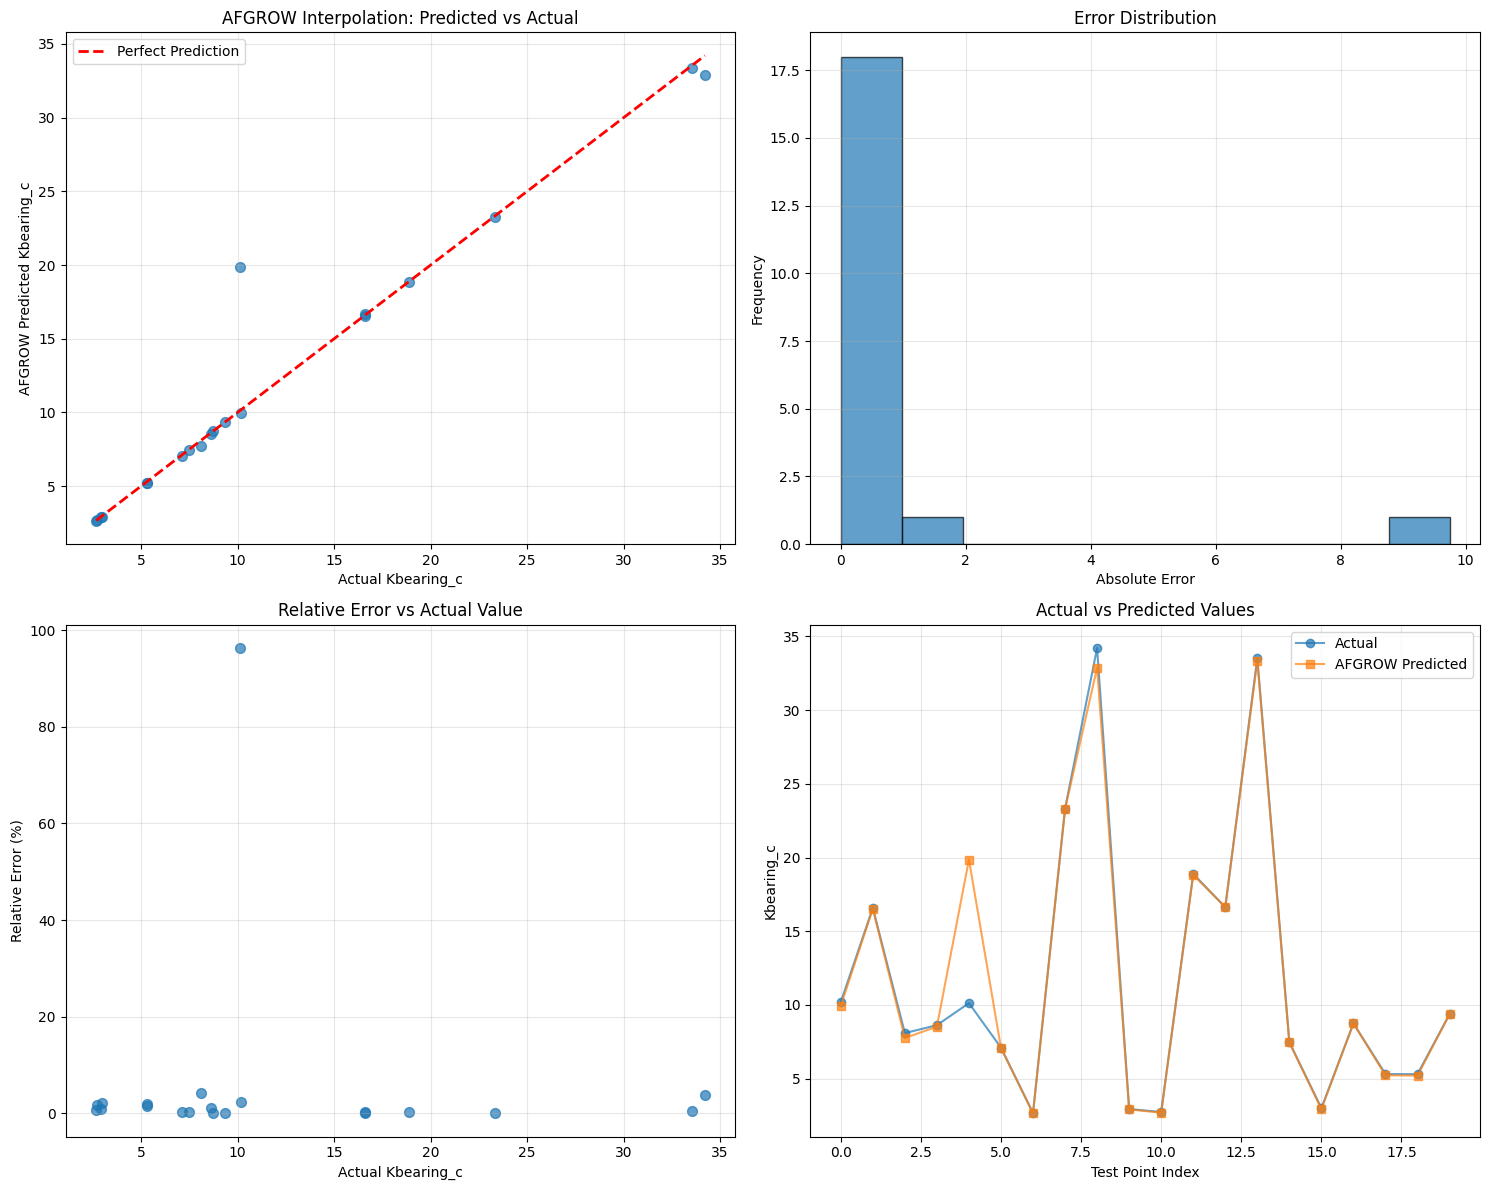


📈 AFGROW Interpolation Performance Metrics:
R² Score: 0.9428
Mean Squared Error: 4.846399
Mean Absolute Error: 0.626238
Mean Relative Error: 5.95%


In [5]:
# Visualization: Compare both interpolation methods with actual values
plt.figure(figsize=(16, 12))

# Test on subset of points for cleaner visualization
n_test_points = 50
test_sample = X_test[:n_test_points]
actual_sample = y_test[:n_test_points]

# Get predictions from both methods
afgrow_sample_predictions = afgrow_predictions[:n_test_points]
direct_4d_sample_predictions = direct_4d_predictions[:n_test_points]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Predicted vs Actual scatter plot - AFGROW
axes[0, 0].scatter(actual_sample, afgrow_sample_predictions, alpha=0.7, s=50, color='blue', label='AFGROW')
axes[0, 0].plot([actual_sample.min(), actual_sample.max()], 
                [actual_sample.min(), actual_sample.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Kbearing_c')
axes[0, 0].set_ylabel('Predicted Kbearing_c')
axes[0, 0].set_title('AFGROW Interpolation: Predicted vs Actual')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Predicted vs Actual scatter plot - Direct 4D
axes[0, 1].scatter(actual_sample, direct_4d_sample_predictions, alpha=0.7, s=50, color='green', label='Direct 4D')
axes[0, 1].plot([actual_sample.min(), actual_sample.max()], 
                [actual_sample.min(), actual_sample.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Kbearing_c')
axes[0, 1].set_ylabel('Predicted Kbearing_c')
axes[0, 1].set_title('Direct 4D Interpolation: Predicted vs Actual')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Combined comparison
axes[0, 2].scatter(actual_sample, afgrow_sample_predictions, alpha=0.6, s=40, color='blue', label='AFGROW')
axes[0, 2].scatter(actual_sample, direct_4d_sample_predictions, alpha=0.6, s=40, color='green', label='Direct 4D')
axes[0, 2].plot([actual_sample.min(), actual_sample.max()], 
                [actual_sample.min(), actual_sample.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0, 2].set_xlabel('Actual Kbearing_c')
axes[0, 2].set_ylabel('Predicted Kbearing_c')
axes[0, 2].set_title('Method Comparison: Predicted vs Actual')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Error distribution comparison
afgrow_sample_errors = np.abs(afgrow_sample_predictions - actual_sample)
direct_4d_sample_errors = np.abs(direct_4d_sample_predictions - actual_sample)

axes[1, 0].hist(afgrow_sample_errors, bins=15, alpha=0.7, edgecolor='black', color='blue', label='AFGROW')
axes[1, 0].hist(direct_4d_sample_errors, bins=15, alpha=0.7, edgecolor='black', color='green', label='Direct 4D')
axes[1, 0].set_xlabel('Absolute Error')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Error Distribution Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Relative error vs actual value
afgrow_relative_errors = afgrow_sample_errors / actual_sample * 100
direct_4d_relative_errors = direct_4d_sample_errors / actual_sample * 100

axes[1, 1].scatter(actual_sample, afgrow_relative_errors, alpha=0.6, s=40, color='blue', label='AFGROW')
axes[1, 1].scatter(actual_sample, direct_4d_relative_errors, alpha=0.6, s=40, color='green', label='Direct 4D')
axes[1, 1].set_xlabel('Actual Kbearing_c')
axes[1, 1].set_ylabel('Relative Error (%)')
axes[1, 1].set_title('Relative Error vs Actual Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Prediction vs point index
indices = range(len(actual_sample))
axes[1, 2].plot(indices, actual_sample, 'o-', label='Actual', alpha=0.8, markersize=4)
axes[1, 2].plot(indices, afgrow_sample_predictions, 's-', label='AFGROW', alpha=0.7, markersize=4)
axes[1, 2].plot(indices, direct_4d_sample_predictions, '^-', label='Direct 4D', alpha=0.7, markersize=4)
axes[1, 2].set_xlabel('Test Point Index')
axes[1, 2].set_ylabel('Kbearing_c')
axes[1, 2].set_title('Actual vs Predicted Values (First 50 Points)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance metrics comparison
def calculate_metrics(actual, predicted):
    r2 = 1 - np.sum((actual - predicted)**2) / np.sum((actual - np.mean(actual))**2)
    mse = np.mean((actual - predicted)**2)
    mae = np.mean(np.abs(actual - predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return r2, mse, mae, mape

# Calculate metrics for both methods
afgrow_r2, afgrow_mse, afgrow_mae, afgrow_mape = calculate_metrics(actual_sample, afgrow_sample_predictions)
direct_4d_r2, direct_4d_mse, direct_4d_mae, direct_4d_mape = calculate_metrics(actual_sample, direct_4d_sample_predictions)

print(f"\n📈 Performance Metrics Comparison (First {n_test_points} test points):")
print(f"\n🔵 AFGROW Interpolation:")
print(f"  R² Score: {afgrow_r2:.4f}")
print(f"  Mean Squared Error: {afgrow_mse:.6f}")
print(f"  Mean Absolute Error: {afgrow_mae:.6f}")
print(f"  Mean Absolute Percentage Error: {afgrow_mape:.2f}%")

print(f"\n🟢 Direct 4D Interpolation:")
print(f"  R² Score: {direct_4d_r2:.4f}")
print(f"  Mean Squared Error: {direct_4d_mse:.6f}")
print(f"  Mean Absolute Error: {direct_4d_mae:.6f}")
print(f"  Mean Absolute Percentage Error: {direct_4d_mape:.2f}%")

print(f"\n🏆 Winner:")
if afgrow_r2 > direct_4d_r2:
    print(f"  AFGROW method has better R² score ({afgrow_r2:.4f} vs {direct_4d_r2:.4f})")
else:
    print(f"  Direct 4D method has better R² score ({direct_4d_r2:.4f} vs {afgrow_r2:.4f})")

if afgrow_mae < direct_4d_mae:
    print(f"  AFGROW method has lower MAE ({afgrow_mae:.6f} vs {direct_4d_mae:.6f})")
else:
    print(f"  Direct 4D method has lower MAE ({direct_4d_mae:.6f} vs {afgrow_mae:.6f})")